In [3]:
import mne
import numpy as np
import pandas as pd
from scipy import stats
import scipy.sparse as sparse
import mne.io 
from mne.stats import permutation_cluster_1samp_test
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import pingouin as png
pd.set_option("display.max_rows", None, "display.max_columns", None)


In [ ]:
# files needed:
# one random raw .edf file from the sample (to calculate channel neighborhood connectivity matrix)
# neuronal (lrtc or other, optionally) data and behavioral data in te folloving format: 
# rows - participants, columns - channels and behavioral data

In [12]:
# functions that calculate simple correlations with stats.spearmanr
# returns only rho values
def cor_r(dat, beh):
    rho=[0]*nsrc
    pval=[0]*nsrc
    for i in range (nsrc):
        rho[i],pval[i]=stats.spearmanr(dat[:,i],beh, nan_policy='omit')
    return np.array(rho)

# returns only p-value
def cor_p(dat, beh):
    rho=[0]*nsrc
    pval=[0]*nsrc
    for i in range (nsrc):
        rho[i],pval[i]=stats.spearmanr(dat[:,i],beh, nan_policy='omit')
    return np.array(pval)

# main function for cluster test: computes spearman correlation and returns rho to t-statistics
def get_t(data):
    t_stat=[0]*nsrc
    rho=[0]*nsrc
    pval=[0]*nsrc
    for i in range (nsrc):
        rho[i],pval[i]=stats.spearmanr(data[:,i],beh, nan_policy='omit')
        t_stat[i]=rho[i]*(np.sqrt(data.shape[0]-2))/np.sqrt((1-rho[i]*rho[i]))
    return np.array(t_stat)

# partial correlation functions 
# returns rho values
import pingouin as png
def cor_r_partial(data):
    rho=[0]*nsrc
    for i in range (nsrc):
        df = pd.DataFrame(index=range(0,len(beh)), data={'beh': beh, 'neuro': neuro[:,i], 'sex': dat['pcqI02an']})
        rho[i] = png.partial_corr(data=df, x='beh', y='neuro', covar='sex', method='spearman')['r'][0]
    return np.array(rho, dtype='float')

# returns p-value
def cor_p_partial(data):
    pval=[0]*nsrc
    for i in range (nsrc):
        df = pd.DataFrame(index=range(0,len(beh)), data={'beh': beh, 'neuro': neuro[:,i], 'sex': dat['pcqI02an']})
        pval[i] = png.partial_corr(data=df, x='beh', y='neuro', covar='sex', method='spearman')['p-val'][0]
    return np.array(pval, dtype='float')

# main function for partial correlation in cluster test: computes spearman correlation and returns rho to t-statistics
def get_t_partial(data):
    t_stat=[0]*nsrc
    rho=[0]*nsrc
    pval=[0]*nsrc
    for i in range (nsrc):
        df = pd.DataFrame(index=range(0,len(beh)), data={'beh': beh, 'neuro': neuro[:,i], 'sex': dat['pcqI02an']})
        pval[i] = png.partial_corr(data=df, x='beh', y='neuro', covar='sex', method='spearman')['p-val'][0]
        rho[i] = png.partial_corr(data=df, x='beh', y='neuro', covar='sex', method='spearman')['r'][0]
        t_stat[i]=rho[i]*(np.sqrt(data.shape[0]-2))/np.sqrt((1-rho[i]*rho[i]))
    return np.array(t_stat)


In [64]:
## load data for cluster test 
# the data should be in format (rows=individuals, columns=activity_sources+behavioral data)
# !!! the sequence of channels in the data must be the same as in connectivity matrix, 
# !!! the following columns are behavioral data

# set path
main_dir='/Volumes/One Touch/Barracuda/Autoreject/'
#main_dir='H:/IQ-2(Chb-Msk)/' 
out_dir = main_dir+'Cl_Test/'

# set data loading configurations
# sensor space or source space
level = 'SNS' 
# type of neuronal data 
datatype = 'lrtc'
# number of sources
nsrc = 64
# frequency boundaries
l_freq = 8 # low frequency 
h_freq = 12 # high frequency
freq = str(l_freq)+'_'+str(h_freq)
# sex: also can be male or female or all
sex = 'all'

# load data
dat = pd.read_csv(out_dir+level+'_'+datatype+'_'+freq+'_'+sex+'.csv')
n_subjects = dat.shape[0]

# choose data
# neuronal data for each participant for each channel, lrtc\power\etc.
neuro = np.array(dat.iloc[:,0:nsrc], dtype=float) 
# behavioral data but you can only use 1 variable for cluster permutation test
# so find out which number of behavioral data column to fetch from dataframe
# with which you want to test the correlations
ntask = 66
beh = np.array(dat.iloc[:,ntask], dtype=float) 
# name of the task
taskstr =  dat.columns[ntask] 

print('Data type:', datatype)
print('N subjects:', n_subjects)
print('N sensors:', neuro.shape[1])
print('Frequecy band:', freq)
print('Cognitive task:', taskstr)

Data type: lrtc
N subjects: 105
N sensors: 64
Frequecy band: 8_12
Cognitive task: pcpvtot.x


In [7]:
# load information about connectivity between EEG sensor channels
raw = mne.io.read_raw_fif(main_dir+'FIF/1213_FON1-raw.fif', preload=True)
#raw = mne.io.read_raw_fif(main_dir+'FIF/load8_Connectivity_raw.fif', preload=True)
order = raw.ch_names
new_order = sorted(order)
raw_new = raw.copy().reorder_channels(new_order)
position = raw_new.info
montage = mne.channels.make_standard_montage('standard_1005')
raw_new.set_montage(montage)
connectivity={}
ch_names={}
connectivity, ch_names = mne.channels.find_ch_adjacency(raw_new.info, ch_type = 'eeg')
position = raw_new.info
print(ch_names)
type(connectivity)

Opening raw data file /Volumes/One Touch/Barracuda/Autoreject/FIF/1213_FON1-raw.fif...
    Range : 0 ... 151337 =      0.000 ...   605.348 secs
Ready.
Reading 0 ... 151337  =      0.000 ...   605.348 secs...
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 64
['AF3', 'AF4', 'AF7', 'AF8', 'AFz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz', 'Cz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCz', 'FT10', 'FT7', 'FT8', 'FT9', 'Fp1', 'Fp2', 'Fz', 'O1', 'O2', 'Oz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4', 'PO7', 'PO8', 'POz', 'Pz', 'T7', 'T8', 'TP10', 'TP7', 'TP8', 'TP9']


scipy.sparse.csr.csr_matrix

[False False  True  True  True  True  True  True  True False  True  True
  True False  True  True  True  True  True False  True  True  True  True
  True  True  True  True False  True False  True False False False  True
  True  True False  True  True  True  True  True  True  True  True  True
 False False False False False False False False  True False False False
 False False  True  True]
Max: 0.2648303905154887 Min 0.12860423951159947
p-value threshold: 0.05


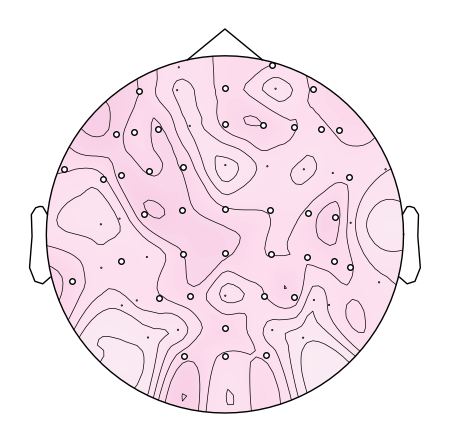

In [34]:
## briefly run simple Spearcman correlation: is there any corrrelation at all?

# set the p value threshold to find out which correlations are significant
p_threshold = 0.05
# automatically calculate p threshold into corresponding t-value
t_threshold = -stats.distributions.t.ppf(p_threshold / 2., n_subjects - 1)
tr = str(p_threshold)
tr = tr.replace(".", "")

# run
rho=cor_r(neuro, beh)
pval=cor_p(neuro, beh)

# check which of the correlations are significant
true_cor=pval<=p_threshold
print(true_cor)
rho_max=max(rho) # can be used to plot the association 
rho_min=min(rho) # can be used to plot the association 
print('Max:', rho_max, 'Min', rho_min)
print('p-value threshold:', p_threshold)
plot,_=mne.viz.plot_topomap(rho, position, vmin=-1,vmax=1, contours=6,
                           cmap='PiYG_r', axes=None, mask=true_cor, show=True)
#cbar=plt.colorbar(plot, label='\u03C1')

[False False  True  True  True  True  True  True  True False  True  True
  True False  True False  True  True  True False  True  True  True  True
 False  True  True  True False  True False  True False False False False
 False  True False  True  True  True False False  True False False  True
 False False False False False False False False  True False False False
 False False  True  True]
Max: 0.2632772070731498 Min 0.1156587778710491
p-value threshold: 0.05


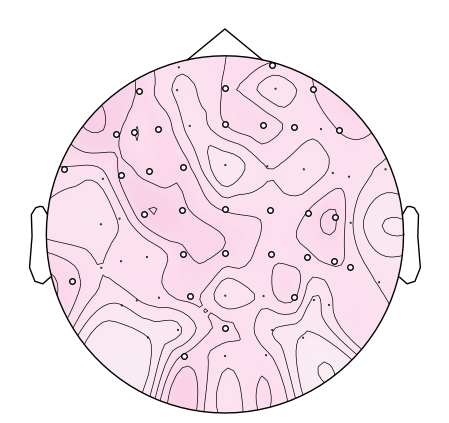

In [35]:
## run partial correlartion test
rho=cor_r_partial(neuro)
pval=cor_p_partial(neuro)

# check which of the correlations are significant
true_cor=pval<=p_threshold
print(true_cor)
rho_max=max(rho)
rho_min=min(rho)# can be used to plot the association 
print('Max:', rho_max, 'Min', rho_min)
print('p-value threshold:', p_threshold)
plot,_=mne.viz.plot_topomap(rho, position, vmin=-1,vmax=1, contours=6,
                           cmap='PiYG_r', axes=None, mask=true_cor, show=True)
#cbar=plt.colorbar(plot, label='\u03C1')

In [36]:
# see what FDR correction does with significant for pvalues
# well they all become insignificant
from mne.stats import fdr_correction
rejects, pvalues = fdr_correction(pval, alpha=0.05)
print('Recects:', rejects)
print('New p-values:', pvalues)

Recects: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
New p-values: [0.11057606 0.13846717 0.09584728 0.09584728 0.09584728 0.09584728
 0.09584728 0.09584728 0.09584728 0.09804679 0.09584728 0.09584728
 0.09584728 0.10196987 0.09584728 0.09584728 0.09584728 0.09584728
 0.09584728 0.11373367 0.09584728 0.09584728 0.09584728 0.09584728
 0.09728275 0.09584728 0.09584728 0.09584728 0.10260959 0.09584728
 0.13566395 0.09584728 0.09804679 0.22113512 0.11070507 0.09728275
 0.09728275 0.09584728 0.10111643 0.09584728 0.09584728 0.09584728
 0.09804679 0.09728275 0.09584728 0.09728275 0.09584728 0.09584728
 0.10405167 0.16765895 0.15558191 0.11311531 0.168

In [37]:
# run CLUSTER PERMUTATION TEST for p values
t_obs, clusters, cluster_pv, H0 = permutation_cluster_1samp_test(neuro, threshold = t_threshold, n_permutations = 1000, 
                                                                 stat_fun = get_t, adjacency = connectivity, 
                                                                 verbose = None, buffer_size= None, out_type='mask')


stat_fun(H1): min=1.316120 max=2.787254
Running initial clustering
Found 2 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [44]:
# check cluster p-values
print('p values of all clusters:', cluster_pv)
good_cluster_inds = np.where(cluster_pv < 0.05)[0]
gclpv = cluster_pv[good_cluster_inds] # be careful with this one: it wokrs only if we have significant clusters
print("Indexes of clusters, significant at", gclpv, ':', good_cluster_inds)
print(good_cluster_inds)
clpv = str(gclpv).replace(".", "")

p values of all clusters: [0.047 0.129]
Indexes of clusters, significant at [0.047] : [0]
[0]
[0047]


In [ ]:
# create a mask of clusters to save the results
bools = [False]*nsrc
sources = np.array(range(0,nsrc))
for i in range(0,len(clusters)):
    if i in good_cluster_inds:
        for n in range(0,len(sources[clusters[i]])):
            bools[sources[clusters[i]][n]] = True
    elif i not in good_cluster_inds:
        for n in range(0,len(sources[clusters[i]])):
            bools[sources[clusters[i]][n]] = False

In [ ]:
# prepare the dataframe with results and save
mask = bools

ch_names = np.arange(nsrc)
zeros = [0]*nsrc
df = pd.DataFrame({'cluster' : mask, 'neuro' : zeros, 'rho' : rho, 'ch_names' : ch_names})
for i in range(0,nsrc):
    if df.iloc[i,0] == True:
        df.iloc[i,1] = df.iloc[i,2]
        
print(df)

t = {'mask': df['cluster'], 'rho': rho}
t = pd.DataFrame(t)
t

t.to_csv(main_dir+'/SNS_clust_'+str(datatype)+'_'+str(taskstr)+'_'+str(freq)+'_'+str(tr)+'_'+str(clpv)+str(sex)+'.csv', sep = ',', index = False)

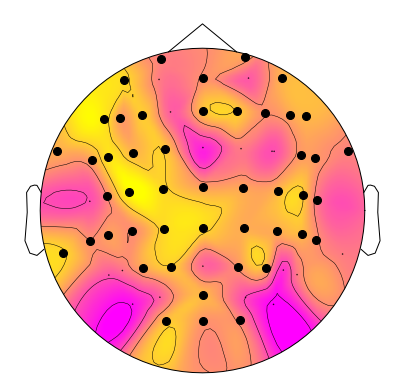

NameError: name 'clpv' is not defined

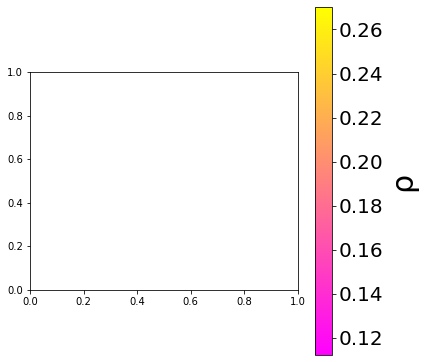

In [21]:
# some visualisation stuff
cluster = pd.read_csv('H:/Autoreject/Cl_Test/Final/SNS_clust_lrtc_pcpvtot.x_8_12_005_0031all_partial.csv')
rho = np.array(cluster.iloc[:,1])
mask = np.array(cluster.iloc[:,0])
# illustration of permutation test
#position = pd.read_csv('/home/anna/Python/LRTC/location.csv')
#position = np.array(position)
#print(position)

#cluster=clusters[0]
#cluster=np.array(cluster)
#mask=np.any(clusters,axis=0)
#plot,_=mne.viz.plot_topomap(rho812, position, vmin=-1,vmax=1, contours=6,
#                           cmap='PiYG_r', axes=None, mask=mask812, show=True)
#cbar1 = plt.colorbar(plot, axes=None)
#print(plot)
dick = dict(marker='o', markerfacecolor='k', markeredgecolor='k', linewidth=0, markersize=8)

plot, axs = plt.subplots(figsize=(7,7))
plot,_=mne.viz.plot_topomap(rho, position, vmin=np.min(rho), 
                            vmax=np.max(rho), contours=4, cmap='spring', mask=mask, mask_params=dick,
                            show=True) #mask=mask, 

cbar=plt.colorbar(plot, shrink=1.6)
cbar.set_label(label='\u03C1',size=30)
cbar.ax.tick_params(labelsize=20)

filename = 'clust_pv_'+str(freq)+'_'+str(tr)+'_'+str(clpv)
print(filename)

0.00881227186864108


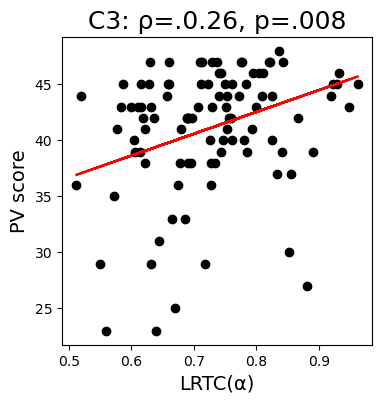

In [61]:
# visualize individual channel with highest corretalion

# slope intercept function
def slope_intercept(x_val,y_val):
    x=np.array(x_val)
    y=np.array(y_val)
    m=(((np.nanmean(x)*np.nanmean(y)) - np.nanmean(x*y)) / ((np.nanmean(x)*np.nanmean(x)) - np.nanmean(x*x)))
    m=round(m,2)
    b=(np.nanmean(y)-np.nanmean(x)*m)
    b=round(b,2)
    
    return m,b

# find max rho in results
max_value = max(rho)
max_index = list(rho).index(max_value)
neuro_reg = neuro[:,max_index]
print(pval[max_index])
# choose channel for visualization
m,b=slope_intercept(neuro_reg, beh)
# visualize slope line
reg_line=[(m*x)+b for x in neuro_reg]

fig, ax = plt.subplots()
#print(reg_line)
#plt.axis([0, 0.000007, 0, 30])
   
plt.scatter(neuro_reg, beh, c='Black')
plt.plot(neuro_reg, reg_line, c='red')
plt.ylabel("PV score", fontsize=14)
plt.xlabel("LRTC(\u03B1)", fontsize=14) #lrtc(\u03B1) power((\u03BCV))
#plt.text(3, 4, 'Random Noise', style='italic', fontsize=12,
 #       bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
plt.title("C3: \u03C1=."+str(round(max_value,2))+", p=.008", fontsize=18)
#plt.figure(figsize=(1,1))
plt.rcParams["figure.figsize"] = (4,4)
plt.show() 


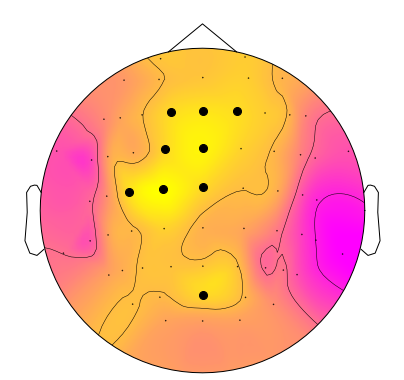

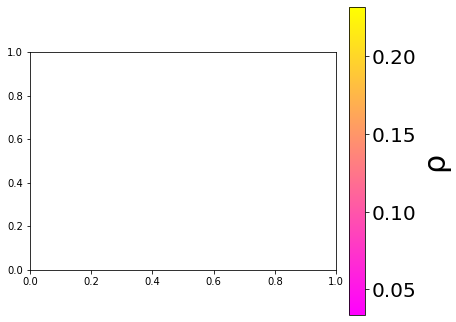

In [24]:
# some more visualization
plot, ax = plt.subplots(figsize=(7,7))
dicts = dict(marker='o', markerfacecolor='k', markeredgecolor='k', linewidth=0, markersize=8)
plot,_=mne.viz.plot_topomap(rho, position, vmin=np.min(rho), vmax=np.max(rho),
                             contours=3, cmap='spring', mask=true_cor, mask_params=dicts,# viridis
                            axes=None, show=True)
cbar = plt.colorbar(plot, label='\u03C1', fraction=0.046, pad=0.04, shrink=2) 
cbar.set_label(label='\u03C1',size=30) # lrtc = (label='\u03C1',size=30) amp = label='\u03BCV',size=30 # lrtc \u03B1 rho=\u03C1
cbar.ax.tick_params(labelsize=20)
plt.show()